# 肺CT画像からのCOVID-19の診断

## 概要

SageMaker のビルトインアルゴリズムである image classification を利用して、肺CT画像をCOVID-19に感染したものか、感染していないものかを分類します。CT画像は、何度もスライスした画像の集合になるため、3次元データ (縦、横、スライス回数）となりますが、今回はスライスされた1枚1枚のCT画像を2次元画像として扱って分類します。2次元の画像であれば、SageMaker のビルトインアルゴリズムである image classificationを適用することができます。

## 画像データ準備

### ダウンロード

COVID-19に感染したX線画像とCT画像が以下で公開されているのでこれを利用します。このデータセットは CC BY 4.0のライセンスで利用可能です。 

https://data.mendeley.com/datasets/8h65ywd2jr/3

El-Shafai, Walid; Abd El-Samie, Fathi (2020), “Extensive COVID-19 X-Ray and CT Chest Images Dataset”, Mendeley Data, V3, doi: 10.17632/8h65ywd2jr.3

まずデータを wget のコマンドでダウンロードしましょう。ダウンロード先の URL は変わる可能性がありますので、必要に応じて変更してください。データのサイズは4GBほどあり、データのダウンロードには5分程度かかります。

ホームディレクトリはデフォルトで数GBのディスク容量しかありません。そこで、より容量の大きい `/tmp` 以下にデータを保存します。
**ホームディレクトリ以外のデータはインスタンスを停止した場合に削除されますので、一旦停止して続きを行う場合は再度ダウンロードしてください**。もしホームディレクトリにデータを永続的に保存したい場合は、インスタンスのディスクのサイズを大きくしてください。

In [ ]:
!wget https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/8h65ywd2jr-3.zip -P /tmp/

### 圧縮データの解凍

ダウンロードしたデータをさらに `/tmp` に解凍します。解凍すると`COVID-19 Dataset.zip`という zip ファイルが現れるので、これもさらに `/tmp` に解凍します。解凍したあとのデータセットの構造は以下のようになっています。

- /tmp
  - /CT
    - /COVID
    - /Non-COVID
  - /X-ray
    - /COVID
    - /Non-COVID
    
`CT` フォルダにはCT画像が、`X-ray`フォルダにはX線画像があり、それぞれ COVIDの場合とNon-COVIDの場合に別々のフォルダで画像が保存されています。

In [ ]:
!unzip /tmp/8h65ywd2jr-3.zip -d /tmp
!unzip /tmp/COVID-19\ Dataset.zip -d /tmp

### 画像の確認


In [ ]:
%matplotlib inline
import random
from PIL import Image
import matplotlib.pyplot as plt
import os 

CT_cov_dir = '/tmp/COVID-19 Dataset/CT/COVID/'
CT_noncov_dir = '/tmp/COVID-19 Dataset/CT/Non-COVID/'
cov_path = [CT_cov_dir + path for path in os.listdir(CT_cov_dir)]
non_cov_path = [CT_noncov_dir + path for path in os.listdir(CT_noncov_dir)]

choice_cov = random.randint(0,len(cov_path)-1)
choice_noncov = random.randint(0,len(non_cov_path)-1)

cov_im = Image.open(cov_path[choice_cov])
non_cov_im = Image.open(non_cov_path[choice_noncov])

plt.subplot(1,2,1)
plt.imshow(cov_im, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(non_cov_im, cmap='gray')

### 画像データのアップロード

今回はCT画像のみを利用しますので、`/tmp/COVID-19 Dataset/CT/` 以下をアップロードします。アップロードには、sagemaker の Python SDK に用意されている upload_data 関数を利用します。アップロード完了までに10分ほどかかります。


In [ ]:
%%time
import sagemaker

sagemaker_session = sagemaker.Session()
from sagemaker import get_execution_role

role = get_execution_role()

CTImage_data = sagemaker_session.upload_data(
        path='/tmp/COVID-19 Dataset/CT/',
        key_prefix='2D-CTImage-COVID-19')

## 拡張マニフェストファイルの作成

機械学習を行うためには、さきほどアップロードした画像に加えて、その画像が COVID-19 かどうかを示すラベルを付与する必要があります。SageMaker の image classification では、画像データとラベルを以下のファイル形式で入力することができます。以下の URL に詳細が記載されています。

https://docs.aws.amazon.com/ja_jp/sagemaker/latest/dg/image-classification.html#IC-inputoutput

- lst ファイル  
  画像のインデックス、ラベル、S3上の画像パスをタブ区切りで記述したファイル
- record-IO ファイル  
  画像データとラベルをバイナリ形式でまとめたファイル
- 拡張マニフェストファイル  
  ラベルとS3上の画像パスを複数行の json 形式 (jsonlines) で記述したファイル
  
lst ファイルと拡張マニフェストファイルは画像へのパスを指定するため、別途、S3に画像データをアップロードする必要があります。今回はすでに S3に画像をアップロード済みですので、それらを利用可能です。S3 にアップロードされたファイルを学習時にダウンロードする方式として、ファイルモードとパイプモードの2種類があります。上記のファイルによって利用可能なモードが異なります。

| ファイル形式 | ファイルモード | パイプモード |
| --- | --- | --- |
| lst | 利用可 | 利用不可 |
| RecordIO | 利用可 | 利用可 |
| 拡張マニフェスト | 利用不可 | 利用可 |


**ファイルモード**は学習用インスタンスにすべての学習データをダウンロードしてから学習を開始し、**パイプモード**は学習データを逐次ダウンロードして学習を行います。そのためパイプモードは、すべての学習データのダウンロードを待つ必要がなく、すぐに学習を始めることができます。特にデータセットが大規模な場合に有効です。

ここでは拡張マニフェストファイルを作成してパイプモードで学習してみましょう。

### 学習データ・バリデーションデータ・テストデータの分離

ここではデータの 80% を学習用のデータに、残り 20% をテストデータに分けた後、80％ の学習用のデータをさらに学習データとバリデーションデータに分離します。COVID-19に感染している画像とそうでない画像があるので、それぞれ上記のとおりに分けてから、

```python
train_s3_path = train_cov_s3path + train_noncov_s3path
```
のようにリストを結合しています。 
ラベルも必要なので、COVID-19 に感染しているものを 1、感染していないものを 0 としてリストを作り結合します。
例えば以下のように行います。
```python
train_label = [1 for _ in range(len(train_cov_s3path))] + [0 for _ in range(len(train_noncov_s3path))]
```


In [ ]:
from sklearn.model_selection import train_test_split

cov_s3path = [CTImage_data +'/COVID/'+ path for path in os.listdir(CT_cov_dir)]
noncov_s3path = [CTImage_data +'/Non-COVID/'+ path for path in os.listdir(CT_noncov_dir)]

train_cov_s3path, test_cov_s3path = train_test_split(cov_s3path, train_size = 0.8)
train_cov_s3path, valid_cov_s3path = train_test_split(train_cov_s3path, train_size = 0.8)
train_noncov_s3path, test_noncov_s3path = train_test_split(noncov_s3path, train_size = 0.8)
train_noncov_s3path, valid_noncov_s3path = train_test_split(train_noncov_s3path, train_size = 0.8)

train_s3_path = train_cov_s3path + train_noncov_s3path
valid_s3_path = valid_cov_s3path + valid_noncov_s3path
test_s3_path = test_cov_s3path + test_noncov_s3path

train_label = [1 for _ in range(len(train_cov_s3path))] + [0 for _ in range(len(train_noncov_s3path))]
valid_label = [1 for _ in range(len(valid_cov_s3path))] + [0 for _ in range(len(valid_noncov_s3path))]
test_label = [1 for _ in range(len(test_cov_s3path))] + [0 for _ in range(len(test_noncov_s3path))]

### 拡張マニフェストファイルへの出力

データの分離ができたら拡張マニフェストファイルへ出力しましょう。まずは、**画像ファイルのパス**と**対応するラベル**をペアにしてリストを作って、学習データ、バリデーションデータそれぞれに対して `train_lines` と `valid_lines` にリストを保存します。**ペアを作ったら学習データは順番を必ずシャッフルしましょう**。シャッフルされていないと学習がうまくすすみません。

シャッフルが終われば後はファイルへの書き出しです。拡張マニフェストファイルは以下のようなフォーマットです。  
https://docs.aws.amazon.com/ja_jp/sagemaker/latest/dg/image-classification.html#IC-inputoutput
```
{"source-ref":"s3://image/filename1.jpg", "class":"0"}
{"source-ref":"s3://image/filename2.jpg", "class":"1"}
```

In [ ]:
import json
train_manifest_name = 'train.manifest'
valid_manifest_name = 'valid.manifest'

train_lines = [[path, label] for path, label in zip(train_s3_path, train_label)]
valid_lines = [[path, label] for path, label in zip(valid_s3_path, valid_label)]
random.shuffle(train_lines)

with open(train_manifest_name, 'w') as f:
    for train in train_lines:
        json.dump({'source-ref': train[0], 'class': train[1]}, f)
        f.write('\n')
        
with open(valid_manifest_name, 'w') as f:
    for valid in valid_lines:
        json.dump({'source-ref': valid[0], 'class': valid[1]}, f)
        f.write('\n')

### 拡張マニフェストファイルのアップロード

ファイルの出力が終われば、sagemaker python sdk の upload_data を使って拡張マニフェストファイルを S3 にアップロードします。拡張マニフェストファイルの属性として、学習時にRecordIO形式で扱うこと、ファイルの中で考慮する属性が `source-ref` や `class`であることを記述します。

In [ ]:
from sagemaker.inputs import TrainingInput

train_manifest_path = sagemaker_session.upload_data(path='train.manifest',key_prefix='2D-CTImage-COVID-19')
valid_manifest_path = sagemaker_session.upload_data(path='valid.manifest',key_prefix='2D-CTImage-COVID-19')

train_data = TrainingInput(train_manifest_path,
                            distribution='FullyReplicated',
                            s3_data_type='AugmentedManifestFile',
                            content_type='application/x-recordio',
                            record_wrapping='RecordIO',
                            attribute_names=['source-ref', 'class'])

valid_data = TrainingInput(valid_manifest_path,
                            distribution='FullyReplicated',
                            s3_data_type='AugmentedManifestFile',
                            content_type='application/x-recordio',
                            record_wrapping='RecordIO',
                            attribute_names=['source-ref', 'class'])

## 学習

ビルトインアルゴリズムの image classification を使った学習を行います。image classification 用のコンテナのイメージの場所は`image_uris.retrieve` で探すことができます。

イメージの場所を取得したらEstimator を定義します。image classification では、p2 や p3 といった GPU のインスタンスのみ学習に利用できます。また拡張マニフェストファイルの場合、ファイルの入力はパイプモードしか対応していないため、`input_mode` を `Pipe` にしましょう。

ハイパーパラメータでは、CT画像はモノクロであるためチャネル数は1です。Image classification がデフォルトで224x224の画像を想定しているので、それにあわせて、`image_shape` は 1, 224 ,224 にします。
ここでは10分程度かけて10エポックのみ学習を実行します。10エポックの学習で、90%程度の精度が得られることが多いです。

In [ ]:
training_image = sagemaker.image_uris.retrieve('image-classification', sagemaker_session.boto_region_name)

estimator = sagemaker.estimator.Estimator(training_image,
                                     role, 
                                     instance_count=1, 
                                     input_mode = 'Pipe',
                                     instance_type='ml.p3.2xlarge')

estimator.set_hyperparameters(image_shape="1,224,224",
                               num_training_samples=len(train_s3_path),
                               num_classes=2,
                               epochs=10,
                               resize = 256)

それでは先ほどの拡張マニフェストファイルを指定して、`fit` で学習を回しましょう。

In [ ]:
data_channels = {'train': train_data, 'validation': valid_data}
estimator.fit(inputs=data_channels, logs=True)

## 推論

### モデルのデプロイ

学習したモデルを `deploy` を使ってデプロイしましょう。エンドポイントの content_type は `application/x-image` を指定する必要があります。

In [ ]:
classifier = estimator.deploy(initial_instance_count = 1,instance_type = 'ml.m4.xlarge')
classifier.serializer = sagemaker.serializers.IdentitySerializer(content_type = 'application/x-image')

### 推論リクエスト

テストデータの画像から、COVID-19が陽性のものを5枚、陰性のものを5枚選んで推論を実行します。画像はバイナリ形式で読み込んでエンドポイントに送信する必要があります。推論の実行コードは以下になります。
```python
    with open(path, 'rb') as f:
        payload = f.read()
        payload = bytearray(payload)
    result = json.loads(classifier.predict(payload))
```

表示される結果の上段の5枚は陽性（ラベル1が真値)、下段の5枚は陰性 (ラベル0が真値) です。画像の上に予測結果とその確率が表示されます。結果が真値と一致しているものが正解です。

推定結果は陽性の確率と陰性の確率を比較して大きい方を出力しています。実際の診断では、陽性を陰性を誤って診断してしまうことがリスクになるので、例えば、陽性の確率が10%でもあれば陽性を疑う、といった利用方法が考えられます。

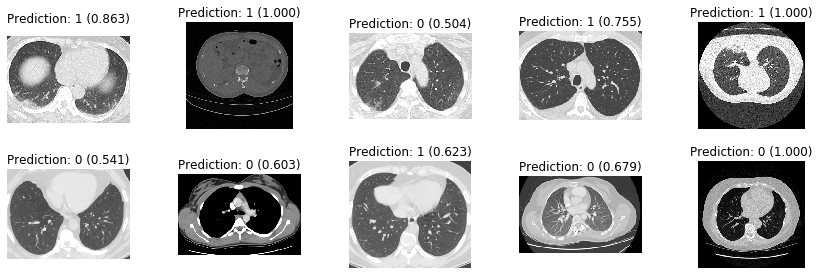

In [105]:
%matplotlib inline
import random
import numpy as np
import matplotlib.pyplot as plt

num_samples = 5
root_dir = '/tmp/COVID-19 Dataset/CT/'
s3_dir =  's3://sagemaker-us-west-2-373011628954/2D-CTImage-COVID-19/'

test_cov_path = [path.replace(s3_dir, root_dir) for path in test_cov_s3path]
test_noncov_path = [path.replace(s3_dir, root_dir) for path in test_noncov_s3path]

cov_indices = random.sample(range(len(test_cov_path) - 1), num_samples)
noncov_indices = random.sample(range(len(test_noncov_path) - 1), num_samples)

fig, axs = plt.subplots(2, num_samples, figsize=(12,4))
fig.tight_layout()

for i in range(num_samples):
    path = test_cov_path[cov_indices[i]]

    with open(path, 'rb') as f:
        payload = f.read()
        payload = bytearray(payload)
    result = json.loads(classifier.predict(payload))
    prediction = np.argmax(result)
    probability = result[prediction]
    
    image = Image.open(path)
    axs[0, i].imshow(image, cmap='gray')
    axs[0, i].set_title("Prediction: {} ({:.3f})".format(prediction, probability))
    axs[0, i].axis('off')

for i in range(num_samples):
    path = test_noncov_path[noncov_indices[i]]

    with open(path, 'rb') as f:
        payload = f.read()
        payload = bytearray(payload)
    result = json.loads(classifier.predict(payload))
    prediction = np.argmax(result)
    probability = result[prediction]
    
    image = Image.open(path)
    axs[1, i].imshow(image, cmap='gray')
    axs[1, i].set_title("Prediction: {} ({:.3f})".format(prediction, probability))
    axs[1, i].axis('off')

### エンドポイントの削除

エンドポイントは実行中課金されますので、不要な場合は、以下のコマンドで削除しましょう。

In [ ]:
classifier.delete_endpoint()